# the goal of this notebook is to extract a dataset that we can use


# imports


In [0]:
import pandas as pd;
import numpy as np;
import os;
import matplotlib.pyplot as plt;

# download data and mount google drive


In [39]:
# Read data from github
!git clone 'https://github.com/extreme4all/OSRS_DataSet'

fatal: destination path 'OSRS_DataSet' already exists and is not an empty directory.


In [40]:
# mounting google drive for storage of weights
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading data in our python notebook


In [0]:
#list files
path = "/content/OSRS_DataSet/RSBUDDY_Prices"
files = os.listdir(path)
### print(files)

#pick files
rsbuddy_files = [f for f in files if 'rsbuddy' in f]
# print(rsbuddy_files)

In [42]:
#initialize empty dataframe
df = pd.DataFrame()

#Loop over list of files to append to empty dataframe
for f in rsbuddy_files:
    data = pd.read_csv(path+'/'+f,names=['item_id','date','buyprice','sellprice','buyquantity','sellquantity'],header=None,parse_dates = ['date'])
    df = df.append(data,sort=True)
    # print("Read File:",f)
# Sample
df.head()

,buyprice,buyquantity,date,item_id,sellprice,sellquantity
0,8415.0,1.0,2019-06-05 20:30:00,10392.0,8415.0,1.0
1,0.0,0.0,2019-06-06 01:00:00,10392.0,8415.0,1.0
2,0.0,0.0,2019-06-06 07:00:00,10392.0,8415.0,1.0
3,0.0,0.0,2019-06-06 07:30:00,10392.0,8415.0,1.0
4,0.0,0.0,2019-06-06 14:30:00,10392.0,8415.0,1.0


# data cleaning


In [43]:
# Remove date errors
df['date'] = pd.to_datetime(df['date'], errors = 'coerce')

df = df[df['date'] > pd.Timestamp('2019-05-25')]
df = df[df['date'] < pd.Timestamp.today()]

mind = df['date'].min()
maxd = df['date'].max()

# Set index
df = df.set_index(['item_id','date'])

# Remove duplicates
df = df.loc[~df.index.duplicated(keep='last')]

# Sample
df.head()

buyprice  buyquantity  sellprice  sellquantity
item_id date                                                               
10392.0 2019-06-05 20:30:00    8415.0          1.0     8415.0           1.0
        2019-06-06 01:00:00       0.0          0.0     8415.0           1.0
        2019-06-06 07:00:00       0.0          0.0     8415.0           1.0
        2019-06-06 07:30:00       0.0          0.0     8415.0           1.0
        2019-06-06 14:30:00       0.0          0.0     8415.0           1.0

In [44]:
r = pd.date_range(start=mind,end=maxd, freq='30min')

# the data with the most amount of data point (48 datapoints = 1 day) (30) minute interval
min_data_points = (maxd-mind)/np.timedelta64(1,'D')*43
print(min_data_points)
t = df.groupby(level='item_id').size()
print(t.describe())
t = t[t>min_data_points]
print(t.describe())
item_id_list = t.index.values

5961.770833333334
count    3555.000000
mean     2630.899015
std      2330.860976
min         1.000000
25%       423.000000
50%      1870.000000
75%      5097.000000
max      6285.000000
dtype: float64
count     556.000000
mean     6189.199640
std        82.632573
min      5966.000000
25%      6149.000000
50%      6216.000000
75%      6261.000000
max      6285.000000
dtype: float64


In [0]:
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std

def replace_outliers(data,parameters):
  df2=data
  for parameter in parameters:
    # calculate summary statistics
    data_mean, data_std = mean(df2[parameter]), std(df2[parameter])
    # identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # identify outliers
    outliers = [x for x in df2[parameter] if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    outliers_removed = [x for x in df2[parameter] if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))

    for x in df2[parameter]:
      if x < lower or x > upper:
        df2 = df2.replace(x,np.median(df2[parameter]))
  return df2

Identified outliers: 1
Non-outlier observations: 6134
Identified outliers: 58
Non-outlier observations: 6077
Identified outliers: 72
Non-outlier observations: 6584
Identified outliers: 1
Non-outlier observations: 6655
Processing Queue:  0
Current progress:  100.0 %
                     buyprice  buyquantity  ...  cost_of_buy  cost_of_sell
2019-10-10 14:00:00    2344.0       2043.0  ...    4788792.0      124232.0
2019-10-10 14:30:00    2462.0        199.0  ...     489938.0      290516.0
2019-10-10 15:00:00    2043.0       2043.0  ...    4173849.0      382041.0
2019-10-10 15:30:00    2043.0       2043.0  ...    4173849.0     3726432.0
2019-10-10 16:00:00    2599.0        200.0  ...     519800.0       44183.0

[5 rows x 7 columns]


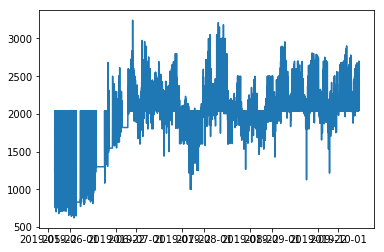

,buyprice,buyquantity,sellprice,sellquantity,item_id,cost_of_buy,cost_of_sell
2019-05-25 00:30:00,160.0,133921.0,158.0,273270.0,2.0,21427360.0,43723200.0
2019-05-25 01:00:00,158.0,152371.0,155.0,724944.0,2.0,24074618.0,114541152.0
2019-05-25 01:30:00,157.0,165685.0,156.0,527227.0,2.0,26012545.0,82774639.0
2019-05-25 02:00:00,157.0,200337.0,156.0,545730.0,2.0,31452909.0,85679610.0
2019-05-25 02:30:00,156.0,117979.0,152.0,567733.0,2.0,18404724.0,88566348.0


In [46]:
from IPython.display import clear_output
# resampling the data
# we could repare the data with a good predicting
i = 1
df_items = pd.DataFrame()
for id in item_id_list:
    clear_output(wait=True)
    # GET THE ITEM
    try:
        data = df.loc[id]
    except:
        continue
    # REMOVE DUPLICATES
    data = data.loc[~data.index.duplicated(keep='last')]
    # REPLACE OUTLIERS
    data = replace_outliers(data,['buyprice','sellprice'])
    # REINDEX MISSING DATES
    try:
        data = data.reindex(r,fill_value=np.nan)
    except:
        continue
    # REPLACE 0 WITH NAN
    data[['buyprice','sellprice']] = data[['buyprice','sellprice']].replace(0,np.nan)
    
    
    # FILL NAN
    # FILL NAN WITH LAST KNOW VALUE
    data[['buyprice','sellprice']] = data[['buyprice','sellprice']].fillna(method='ffill')
    data[['buyprice','sellprice']] = data[['buyprice','sellprice']].fillna(np.round(data.mean(),0))
    ## INTRAPOLATE FILL FOR OTHER COLUMNS
    # data[['buyquantity','sellquantity']] = data[['buyquantity','sellquantity']].fillna(0)
    data = data.interpolate(method ='linear', limit_direction ='forward')
    data = replace_outliers(data,['buyprice','sellprice'])
    # add extra data
    data['item_id'] = id
    data['cost_of_buy'] = data['buyprice']*data['buyquantity']
    data['cost_of_sell'] = data['buyprice']*data['sellquantity']
    df_items = df_items.append(data)
    
    print("Processing Queue: ",len(item_id_list)-i)
    print("Current progress: ",np.round(i/len(item_id_list)*100,2),"%")
    i+=1
    
    print(df_items.tail())

x = data.index.values
y = data['buyprice']
plt.plot(x,y)
plt.show()
df_items.head()

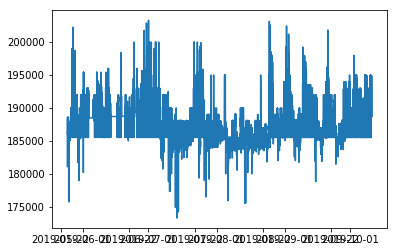

,buyprice,buyquantity,sellprice,sellquantity,item_id,cost_of_buy,cost_of_sell
2019-05-25 00:30:00,181101.0,4.0,180801.0,4.0,6.0,724404.0,724404.0
2019-05-25 01:00:00,186948.0,2.0,185224.0,8.0,6.0,373896.0,1495584.0
2019-05-25 01:30:00,186597.0,3.0,185224.0,4.0,6.0,559791.0,746388.0
2019-05-25 02:00:00,188000.0,2.0,185498.0,7.0,6.0,376000.0,1316000.0
2019-05-25 02:30:00,188137.0,4.0,185515.0,2.0,6.0,752548.0,376274.0


In [47]:
item_id = 6
x = df_items.loc[df_items['item_id'] == item_id].index.values
y = df_items.loc[df_items['item_id'] == item_id]['buyprice']
plt.plot(x,y)
plt.show()
df_items.loc[df_items['item_id'] == item_id].head()

In [0]:
from datetime import date
today = date.today()
# dd/mm/YY
d1 = today.strftime("%d-%m-%Y")
file_name = './drive/My Drive/osrs_prices_{}.pkl'.format(d1)
export_csv = df_items.to_pickle(file_name) #Don't forget to add '.csv' at the end of the path